In [1]:
import random
import numpy as np
import pandas as pd
import manage_data as md
import preprocessing as pp
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import metrics

In [2]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    labels = ['Sticking', 'Fine']
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def concat_df(coil_list):
    big_df = md.importPeak(coil_list[0]).dropna()
    for coil in coil_list[1:]:
        df = md.importPeak(coil).dropna()
        big_df = pd.concat([big_df, df], ignore_index=True)
    return big_df

def create_DB(df):
    feature_col = ['Ximf0', 'Ximf1', 'Ximf2', 'Yimf0', 'Yimf1', 'Yimf2', 'thickness', 'speed']
    X = df[feature_col].values
    Y = df[['sticking']]
    Y = np.array(Y.sticking.values[:], dtype=bool)
    return X, Y

def random_sample(coil_list):
    df = concat_df(coil_list)
    sticking_index = list(df[df.sticking==True].index)
    non_sticking_index = list(df[df.sticking==False].index)
    group_of_items = non_sticking_index               # a sequence or set will work here.
    num_to_select = len(df[df.sticking==True])        # set the number to select here.
    list_of_random_items = random.sample(group_of_items, num_to_select)
    list_of_random_items
    ind = sticking_index+list_of_random_items
    return df.loc[ind]

def result_per_coil(coil_list):
    sum_true = []
    sum_predict = []
    for coil in coil_list:
        df_test = concat_df([coil])
        X_test, Y_true = create_DB(df_test)
        Y_predict = clf.predict(X_test)
        sum_true.append(sum(Y_true))
        sum_predict.append(sum(Y_predict))
    d = {'truth':sum_true, 'prediction':sum_predict}
    result = pd.DataFrame(d, index=coil_list)
    return result, np.array(sum_true), np.array(sum_predict)

# About DB

In [3]:
learning_sticking_coil = sorted([7, 28, 49, 50, 78, 79, 81, 82, 62, 74])
big_sticking_error = [13, 38, 40, 65] + [29, 34, 37, 44, 52, 53, 56] + [4, 17, 20]
learning_fine_coils = sorted([10, 24, 25, 30, 33, 42, 46, 47, 48, 85])
big_fine_error = [36, 77]+[1, 5, 11, 15, 45, 57, 75] + [0, 12, 14, 18, 26, 35, 39, 41, 51, 54, 59, 63, 68, 69, 70, 73, 76, 84, 87]
learning_coils = learning_sticking_coil + learning_fine_coils
learning_coils += big_fine_error
learning_coils += big_sticking_error
testing_coils = list(set(range(88)) - set(learning_coils) - set({31}))
n = len(learning_coils)+len(testing_coils)
nl = int(np.round(len(learning_coils)*100./n,0))
nt = int(np.round(len(testing_coils)*100./n,0))
print(str(nl)+'% learning coils: '+str(len(learning_coils)))
print(str(nt)+'% testing coils: '+str(len(testing_coils)))

71% learning coils: 62
29% testing coils: 25


In [4]:
#df_random_train = random_sample(learning_coils)
#df_random_test = random_sample(testing_coils)

In [5]:
all_coils = list( set(range(88)) - set([31]) )
df_total = concat_df(all_coils)
df_total_train = concat_df(learning_coils)
df_total_test = concat_df(testing_coils)

# Classifier setting

In [20]:
X_train, Y_train = create_DB(df_total_train)
X_test, Y_true = create_DB(df_total_test)
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(X_train, Y_train)

# Result per 4s slice

[[ 15 179]
 [ 13 482]]
[[ 0.07731959  0.92268041]
 [ 0.02626263  0.97373737]]


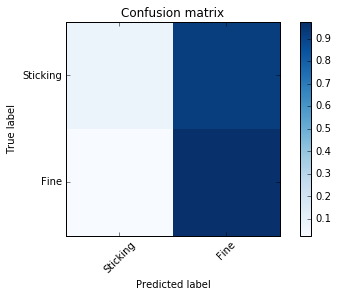

In [21]:
Y_predict = clf.predict(X_test)
cm = metrics.confusion_matrix(Y_true, Y_predict, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print(cm_normalized)

# Show learning DB

[[ 6 18]
 [ 1 37]]


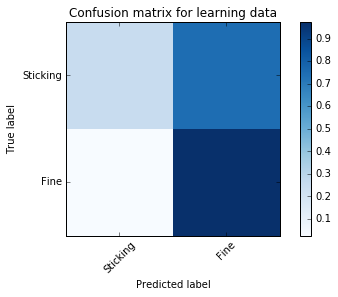

In [22]:
result_DB, sumtrue, sumpredict = result_per_coil(learning_coils)
ytrue = np.greater(sumtrue, 0)
ypredict = np.greater(sumpredict, 3)
cm = metrics.confusion_matrix(ytrue, ypredict, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, 'Confusion matrix for learning data')
print(cm)

[[  83  268]
 [  11 1391]]
[[ 0.23646724  0.76353276]
 [ 0.00784593  0.99215407]]


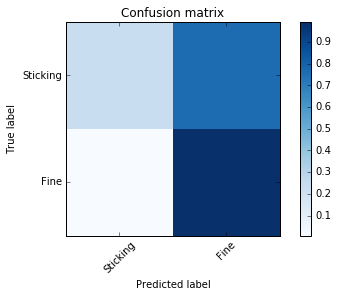

In [23]:
Y_predict = clf.predict(X_train)
cm = metrics.confusion_matrix(Y_train, Y_predict, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print(cm_normalized)

# Result per coil

In [24]:
result, sumtrue, sumpredict = result_per_coil(testing_coils)

[[ 5 10]
 [ 1  9]]
[[ 0.33333333  0.66666667]
 [ 0.1         0.9       ]]


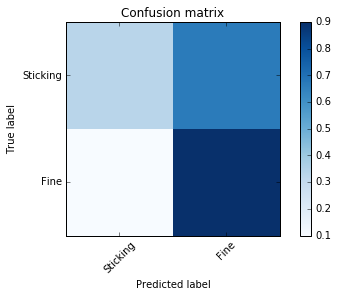

In [26]:
threshold = 1
ytrue = np.greater(sumtrue, 0)
ypredict = np.greater(sumpredict, threshold)
cm = metrics.confusion_matrix(ytrue, ypredict, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print(cm_normalized)

## Sticking detection failure

### False negative

In [12]:
selection = result[(result.truth>0) & (result.prediction<threshold+1)]
l = sorted(list(selection.index))
print(selection)
print(l)
print(len(l))
print(selection.prediction.mean())
print(selection.truth.mean())

    prediction  truth
2            0      8
3            0     15
6            0     10
8            0      7
9            2      1
19           0     20
21           2      7
27           0      8
32           0     12
43           1     13
66           0     10
71           0     29
72           1     27
80           0     15
83           0     12
[2, 3, 6, 8, 9, 19, 21, 27, 32, 43, 66, 71, 72, 80, 83]
15
0.4
12.9333333333


### False positive

In [28]:
selection = result[(result.truth==0) & (result.prediction>threshold)]
l = sorted(list(selection.index))
print(selection)
print(l)
print(len(l))
print(selection.prediction.mean())

    prediction  truth
67           2      0
[67]
1
2.0


In [29]:
sorted(list(selection.index))

[67]

In [30]:
np.abs(sumtrue-sumpredict).mean()

6.8799999999999999

## Data representation

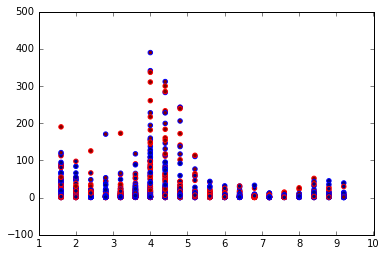

In [31]:
# this formatter will label the colorbar with the correct target names
#formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
plt.scatter(df_total.Ximf2, df_total.Yimf2, c=df_total.sticking, color=["b", "r"])
#plt.colorbar(ticks=[0, 1, 2], format=formatter)
#plt.xlabel(iris.feature_names[x_index])
#plt.ylabel(iris.feature_names[y_index])

# Old code results

[[ 9  3]
 [17 15]]
[[ 0.75     0.25   ]
 [ 0.53125  0.46875]]


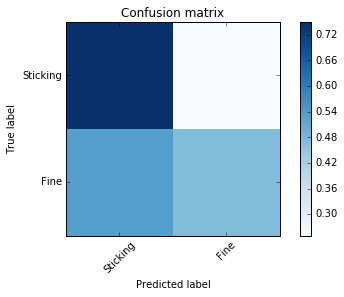

In [32]:
ytrue_old = np.ones(44).astype(bool)
ytrue_old[12:] = False
ytest_old = np.ones(44).astype(bool)
ytest_old[12:] = False
ytest_old[:3] = False
ytest_old[-17:] = True
sum(ytrue_old)
sum(ytest_old)
cm = metrics.confusion_matrix(ytrue_old, ytest_old, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print(cm_normalized)

# Plot sticking and prediction per coil

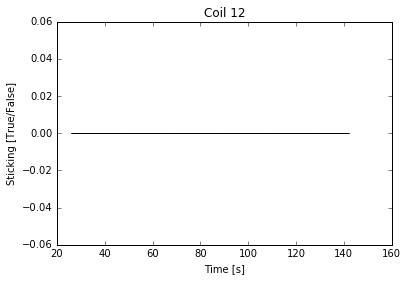

In [35]:
coil = 12 #testing_coils[13]
df_raw = md.import_data(coil)
df_peak = md.importPeak(coil)
df_one_coil = concat_df([coil])
X_coil, Y_coil = create_DB(df_one_coil)
Y_pred_coil = clf.predict(X_coil)
df_one_coil['prediction'] = Y_pred_coil
x = (df_one_coil.time_begin.values + df_one_coil.time_end.values)/2.
plt.title('Coil '+str(coil))
plt.bar(x, df_one_coil.sticking.values,4)
plt.bar(x, 1./2*df_one_coil.prediction.values,4,color='g')
plt.xlabel('Time [s]')
plt.ylabel('Sticking [True/False]')

In [34]:
selection = result[(result.truth>0) & (result.prediction<threshold+1)]
l = sorted(list(selection.index))
print(selection)
print(l)
print(len(l))
print(selection.prediction.mean())
print(selection.truth.mean())

    prediction  truth
2            0      8
3            1     15
6            0     10
8            0      7
19           0     20
27           0      8
32           0     12
66           0     10
71           0     29
80           0     15
[2, 3, 6, 8, 19, 27, 32, 66, 71, 80]
10
0.1
13.4
